To process the data I will first seperate common bond data, convertible bond data, and equity data. 

There are companies which only issue certain types of bond and there are some non-valid data, this process will filter those data out by dropping those non-valid datasets. Then I wll process the data, since there are null values and missing values such as the date for the data can not cover the whole datasets. I will create a list of open trading days for the past 7 years and fillin the missing dates making the whole datasets index based on date.

In [65]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
import os

path = "Data/Original Data"
dir_list = os.listdir(path)
valid_list = []
no_bond = []

for file in dir_list:
    comp_name = file[:-4]
    data = pd.read_csv(os.path.join(path,file))

    data['date'] = pd.to_datetime(data['date'])
    #data.sort_values('date', inplace=True)

    # Calculate the start date (six years before the last date in the dataset)
    start_date = data['date'].max() - pd.DateOffset(years=6)

    # Generate a list of business days (trading days) from the start date to the last date in the dataset
    trading_days = pd.date_range(start=start_date, end=data['date'].max(), freq=BDay())

    # Create a DataFrame from the trading days list
    trading_days_df = pd.DataFrame(trading_days, columns=['Trading Days'])
    trading_days_df = trading_days_df.sort_values(by=['Trading Days'], ascending=False).reset_index()

    # Merge the trading days list with the original dataset
    data['date'] = trading_days_df['Trading Days']

    # Reset index to make 'Trading Days' a column again and rename it to 'date'
    data = data.sort_index(ascending=False)

    try:
        data_conv = data[['date', 'conv_open', 'conv_high', 'conv_low', 'conv_spread']].copy()
        data_stock = data[['date', 'stock_open', 'stock_high', 'stock_low', 'stock_close', 'stock_vol', 'stock_spread']].copy()
        data_conv = data_conv.dropna()
        data_stock = data_stock.dropna()
        data_conv.to_csv(f"Data/Processed Data/{comp_name}_conv.csv", index=False)
        data_stock.to_csv(f"Data/Processed Data/{comp_name}_equ.csv", index=False)
        valid_list.append(comp_name)
    except:
        print(f"Data not valid for {comp_name}")
    
    if comp_name in valid_list:
        try:
            data_com = data[['date', 'com_open', 'com_high', 'com_low', 'com_spread']].copy()
            data_com = data_com.dropna()
            data_com.to_csv(f"Data/Processed Data/{comp_name}_com.csv", index=False)
        except:
            print(f"There is no bond for company {comp_name}")
            no_bond.append(comp_name)
        
    

    

There is no bond for company ABNB
There is no bond for company CAKE
Data not valid for LUV
There is no bond for company MDB
There is no bond for company PANW
There is no bond for company POD
Data not valid for PXD
Data not valid for RCL
There is no bond for company RIVN


Then I will calculate the momentum of the equity by the method proposed in the proposal.

In [66]:
def past_return(data):
    data['Return']=(data['stock_close'].diff()-data['stock_close'].shift(periods=1))/data['stock_close'].shift(periods=1)
    return data

def momentum(data, month):
    momentum = pd.Series(index=data.index, dtype='float64')

    # Calculate momentum for each day where there are enough data points both before and after
    for i in range(len(data)):
        # Ensure we have enough data for both the numerator and the denominator
        if i+6 < len(data) and i-int(21*month)-3 >= 0:
            # Calculate the averages for the numerator and the denominator
            numerator = data['Return'].iloc[i:i+7].mean()
            denominator = data['Return'].iloc[i-int(21*month)-3:i-int(21*month)+3].mean()
            
            # Avoid division by zero
            if denominator != 0:
                # Calculate the momentum
                momentum.iloc[i] = numerator / denominator
    data[f'{month:.2f}x0']=momentum
    for i in range(1, 3):
        data[f'{month:.2f}x0 L{i}']=data[f'{month:.2f}x0'].shift(21*i)
    return data

In [67]:
data_path = "Data/Processed Data"
for comp_name in valid_list:
    data = pd.read_csv(os.path.join(data_path,comp_name+"_equ.csv"), index_col=0)
    data = past_return(data)
    data=momentum(data, 1/3)
    data=momentum(data, 2/3)
    data=momentum(data, 1)
    data=momentum(data, 2)
    data=momentum(data, 3)
    data.to_csv(f"Data/Processed Data/{comp_name}_equ.csv")

Calculate the return of convertible bond using mean of high and low.

In [68]:
data_path = "Data/Processed Data"
for comp_name in valid_list:
    data = pd.read_csv(os.path.join(data_path,comp_name+"_conv.csv"), index_col=0)
    data['conv_mean'] = (data['conv_high']+data['conv_low'])/2
    data['conv_return']=data['conv_mean'].diff()/data['conv_mean'].shift(periods=1)
    data.to_csv(f"Data/Processed Data/{comp_name}_conv.csv")

Then I will combine the datasets back to one but this time seperate the datasets into two, the first categories is the time which there is only convertible bonds but no common bonds. The second categories is there is common bond and convertible bond at the same time.

In [69]:
path_without_bond = "Data/Training Data/Without bond"
path_with_bond = "Data/Training Data/With bond"
for comp_name in valid_list:
    if not comp_name in no_bond:
        data_conv = pd.read_csv(os.path.join(data_path,comp_name+"_conv.csv"))
        data_com = pd.read_csv(os.path.join(data_path,comp_name+"_com.csv"))
        data_equ = pd.read_csv(os.path.join(data_path,comp_name+"_equ.csv"))
        # Ensure date columns are in datetime format
        data_conv['date'] = pd.to_datetime(data_conv['date'])
        data_com['date'] = pd.to_datetime(data_com['date'])
        data_equ['date'] = pd.to_datetime(data_equ['date'])

        # Merge the datasets on the 'date' column, using AAL_conv as the base
        merged_data = data_conv.merge(data_com, on='date', how='left', suffixes=('_conv', '_com'))
        merged_data = merged_data.merge(data_equ, on='date', how='left', suffixes=('', '_equ'))

        
        data_without_bond = merged_data[merged_data['com_open'].isna()].drop(columns=['com_open', 'com_low', 'com_high', 'com_spread'])

        # data2: contains rows where both features are available
        data_without_bond = merged_data.dropna()
        data_with_bond = merged_data.dropna()
        
        data_without_bond.to_csv(os.path.join(path_without_bond, comp_name+'.csv'), index=False)
        data_with_bond.to_csv(os.path.join(path_with_bond, comp_name+'.csv'), index=False)

    else:
        data_conv = pd.read_csv(os.path.join(data_path,comp_name+"_conv.csv"))
        data_equ = pd.read_csv(os.path.join(data_path,comp_name+"_equ.csv"))

        # Ensure date columns are in datetime format
        data_conv['date'] = pd.to_datetime(data_conv['date'])
        data_equ['date'] = pd.to_datetime(data_equ['date'])

        # Merge the datasets on the 'date' column, using AAL_conv as the base
        merged_data = data_conv.merge(data_equ, on='date', how='left', suffixes=('_conv', '_equ'))
        merged_data = merged_data.dropna()
        merged_data.to_csv(os.path.join(path_without_bond, comp_name+'.csv'), index=False)

At this point I want to seperate the data into two categories:
1. Company that issue common bond and convertible bond at the same time
2. Company that issue only convertible bond

Then I will group the data by time and see how many data I can have for each day

In [70]:
df_with_bond = pd.DataFrame()
df_without_bond = pd.DataFrame()
for comp_name in valid_list:
    if comp_name in no_bond:
        data = pd.read_csv(os.path.join(path_without_bond, comp_name+'.csv'))
        data['date'] = pd.to_datetime(data['date'])
        df_without_bond = pd.concat([df_without_bond, data])
    else:
        data = pd.read_csv(os.path.join(path_with_bond, comp_name+'.csv'))
        data['date'] = pd.to_datetime(data['date'])
        df_with_bond = pd.concat([df_with_bond, data])
df_without_bond.sort_values(by='date', inplace=True)
df_with_bond.sort_values(by='date', inplace=True)

In [71]:
from datetime import timedelta

def generate_daily_data(combined_df, path):
    # Get the range of dates in your dataset
    min_date = combined_df['date'].min()
    max_date = combined_df['date'].max()

    # Iterate over each day in the date range
    current_date = min_date
    while current_date <= max_date:
        # Calculate the start date for the 30-day window
        start_date = current_date - timedelta(days=30)

        # Select data from the past 30 days up to the current date
        window_df = combined_df[(combined_df['date'] >= start_date) & (combined_df['date'] <= current_date)]
        
        if len(window_df) < 30:
            current_date += timedelta(days=1)
            continue

        # Save the dataframe to a CSV file named after the current date
        # Replace 'path/to/save/' with your desired save path
        date_str = current_date.strftime('%Y-%m-%d')
        window_df.to_csv(os.path.join(path, date_str+'.csv'), index=False)

        # Move to the next day
        current_date += timedelta(days=1)

In [72]:
path_without_bond = "Data/Training Data/Data by time/Without bond"
path_with_bond = "Data/Training Data/Data by time/With bond"

generate_daily_data(df_without_bond, path_without_bond)
generate_daily_data(df_with_bond, path_with_bond)

Now start to employ boosted regression tree on two datasets. For each dataset, I first use the gried search to find the best combination of hyper parameters, then use that set of parameters to train the real data. First cope with data with no common bond.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

path = "Data/Training Data/Data by time/Without bond"
dir_list = os.listdir(path)

importance = {}
r_2 = {}
errors = {}

# Finding the best combination of parameters
data = pd.read_csv(os.path.join(path, dir_list[-1]))

y=data['conv_return']
X=data.drop(columns=['conv_return', 'date', 'Return'])

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=1000, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
# Fit the grid search to the data
grid_search.fit(X_test, y_test)
# grid_search.best_params_ contains the best parameters found by the search
best_params = grid_search.best_params_



for i, file in enumerate(dir_list):
    data = pd.read_csv(os.path.join(path, file))

    y=data['conv_return']
    X=data.drop(columns=['conv_return', 'date', 'Return'])

    # min_X = []
    # max_X = []
    # min_y = min(y_train)
    # max_y = max(y_train)
    # for feature in X_train.columns:
    #     min_X.append(min(X_train[feature]))
    #     max_X.append(max(X_train[feature]))
    #     X_train[feature]=(X_train[feature]-min(X_train[feature]))/(max(X_train[feature])-min(X_train[feature]))

    # for j, feature in enumerate(X_test.columns):
    #     X_test[feature]=(X_test[feature]-min_X[j])/(max_X[j]-min_X[j])

    # y_train = (y_train-min_y)/(max_y-min_y)
    # y_test = (y_test-min_y)/(max_y-min_y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

    gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=42)
    train_errors = []
    test_errors = []
    train_scores = []
    test_scores = []
    gbr.fit(X_train, y_train)

    date = file[:-4]
    y_train_pred = gbr.predict(X_train)
    y_test_pred = gbr.predict(X_test)
    errors[date] = mean_squared_error(y_test, y_test_pred)
    r_2[date] = r2_score(y_train, y_train_pred)

    imp = gbr.feature_importances_
    feature_names = [f"{i}" for i in X.columns.tolist()]
    forest_importances = pd.Series(imp, index=feature_names)
    importance[date] = forest_importances
    print('Currnet progress: {:.2f}%'.format(i*100/len(dir_list)))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Currnet progress: 0.00%
Currnet progress: 0.08%
Currnet progress: 0.16%
Currnet progress: 0.24%
Currnet progress: 0.33%
Currnet progress: 0.41%
Currnet progress: 0.49%
Currnet progress: 0.57%
Currnet progress: 0.65%
Currnet progress: 0.73%
Currnet progress: 0.82%
Currnet progress: 0.90%
Currnet progress: 0.98%
Currnet progress: 1.06%
Currnet progress: 1.14%
Currnet progress: 1.22%
Currnet progress: 1.31%
Currnet progress: 1.39%
Currnet progress: 1.47%
Currnet progress: 1.55%
Currnet progress: 1.63%
Currnet progress: 1.71%
Currnet progress: 1.79%
Currnet progress: 1.88%
Currnet progress: 1.96%
Currnet progress: 2.04%
Currnet progress: 2.12%
Currnet progress: 2.20%
Currnet progress: 2.28%
Currnet progress: 2.37%
Currnet progress: 2.45%
Currnet progress: 2.53%
Currnet progress: 2.61%
Currnet progress: 2.69%
Currnet progress: 2.77%
Currnet progress: 2.85%
Currnet progress: 2.94%
Currnet progress: 3.02%
Currnet progress: 3.10%
Curr

In [8]:
df_without_importance = pd.DataFrame.from_dict(importance, orient='index')
df_without_error = pd.DataFrame.from_dict(errors, orient='index')
df_without_r_2 = pd.DataFrame.from_dict(r_2, orient='index')

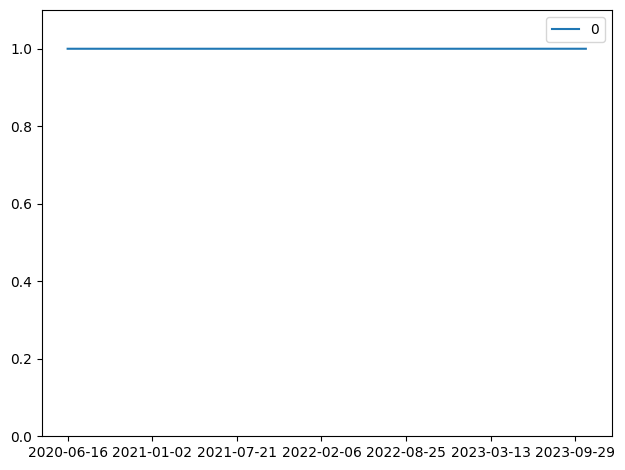

In [9]:
df_without_r_2.plot(ylim=(0, 1.1))
plt.tight_layout()

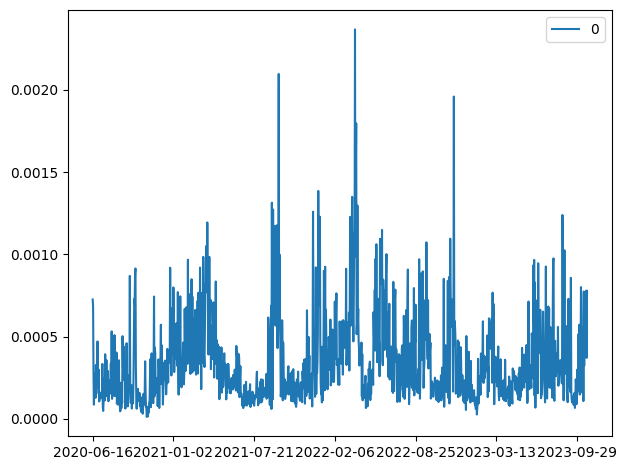

In [14]:
df_without_error.plot()
plt.tight_layout()

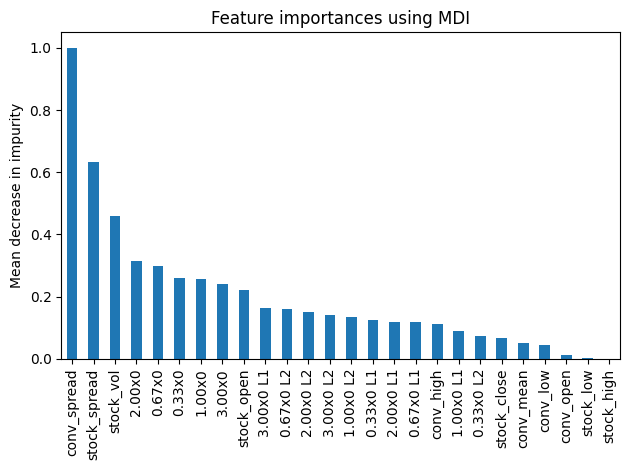

In [16]:
importance_mean = df_without_importance.mean()
importance_mean = (importance_mean-importance_mean.min())/(importance_mean.max()-importance_mean.min())
importance_mean = importance_mean.sort_values(ascending=False)
fig, ax = plt.subplots()
importance_mean[:30].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Now lets train the model using data with bond

In [11]:
path = "Data/Training Data/Data by time/With bond"
dir_list = os.listdir(path)

importance = {}
r_2 = {}
errors = {}

# Finding the best combination of parameters
data = pd.read_csv(os.path.join(path, dir_list[-1]))

y=data['conv_return']
X=data.drop(columns=['conv_return', 'date', 'Return'])

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)
gbr = GradientBoostingRegressor(n_estimators=1000, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, n_jobs=-1, verbose=3)
# Fit the grid search to the data
grid_search.fit(X_test, y_test)
# grid_search.best_params_ contains the best parameters found by the search
best_params = grid_search.best_params_



for i, file in enumerate(dir_list):
    data = pd.read_csv(os.path.join(path, file))

    y=data['conv_return']
    X=data.drop(columns=['conv_return', 'date', 'Return'])

    # min_X = []
    # max_X = []
    # min_y = min(y_train)
    # max_y = max(y_train)
    # for feature in X_train.columns:
    #     min_X.append(min(X_train[feature]))
    #     max_X.append(max(X_train[feature]))
    #     X_train[feature]=(X_train[feature]-min(X_train[feature]))/(max(X_train[feature])-min(X_train[feature]))

    # for j, feature in enumerate(X_test.columns):
    #     X_test[feature]=(X_test[feature]-min_X[j])/(max_X[j]-min_X[j])

    # y_train = (y_train-min_y)/(max_y-min_y)
    # y_test = (y_test-min_y)/(max_y-min_y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42)

    gbr = GradientBoostingRegressor(n_estimators=1000, learning_rate=best_params['learning_rate'], max_depth=best_params['max_depth'], random_state=42)
    train_errors = []
    test_errors = []
    train_scores = []
    test_scores = []
    gbr.fit(X_train, y_train)

    date = file[:-4]
    y_train_pred = gbr.predict(X_train)
    y_test_pred = gbr.predict(X_test)
    errors[date] = mean_squared_error(y_test, y_test_pred)
    r_2[date] = r2_score(y_train, y_train_pred)

    imp = gbr.feature_importances_
    feature_names = [f"{i}" for i in X.columns.tolist()]
    forest_importances = pd.Series(imp, index=feature_names)
    importance[date] = forest_importances
    print('Currnet progress: {:.2f}%'.format(i*100/len(dir_list)))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Currnet progress: 0.00%
Currnet progress: 0.11%
Currnet progress: 0.21%
Currnet progress: 0.32%
Currnet progress: 0.42%
Currnet progress: 0.53%
Currnet progress: 0.63%
Currnet progress: 0.74%
Currnet progress: 0.85%
Currnet progress: 0.95%
Currnet progress: 1.06%
Currnet progress: 1.16%
Currnet progress: 1.27%
Currnet progress: 1.38%
Currnet progress: 1.48%
Currnet progress: 1.59%
Currnet progress: 1.69%
Currnet progress: 1.80%
Currnet progress: 1.90%
Currnet progress: 2.01%
Currnet progress: 2.12%
Currnet progress: 2.22%
Currnet progress: 2.33%
Currnet progress: 2.43%
Currnet progress: 2.54%
Currnet progress: 2.65%
Currnet progress: 2.75%
Currnet progress: 2.86%
Currnet progress: 2.96%
Currnet progress: 3.07%
Currnet progress: 3.17%
Currnet progress: 3.28%
Currnet progress: 3.39%
Currnet progress: 3.49%
Currnet progress: 3.60%
Currnet progress: 3.70%
Currnet progress: 3.81%
Currnet progress: 3.92%
Currnet progress: 4.02%
Curr

In [12]:
df_with_importance = pd.DataFrame.from_dict(importance, orient='index')
df_with_error = pd.DataFrame.from_dict(errors, orient='index')
df_with_r_2 = pd.DataFrame.from_dict(r_2, orient='index')

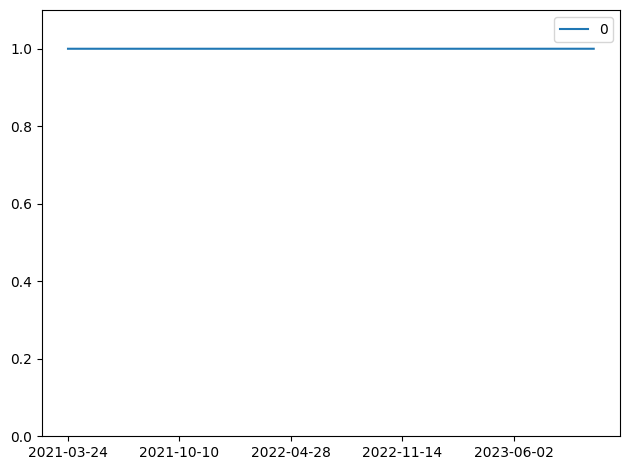

In [13]:
df_with_r_2.plot(ylim=(0, 1.1))
plt.tight_layout()

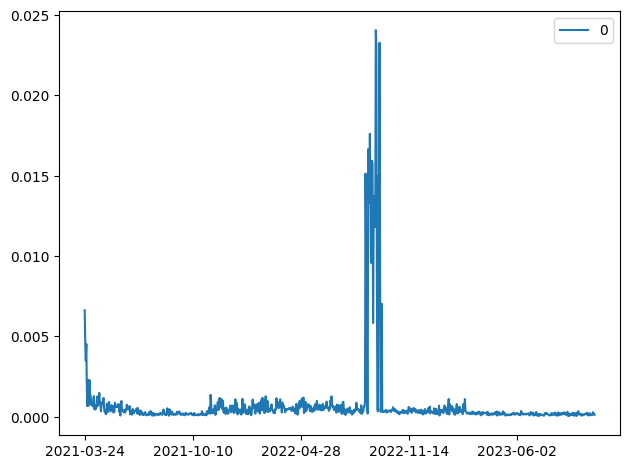

In [17]:
df_with_error.plot()
plt.tight_layout()

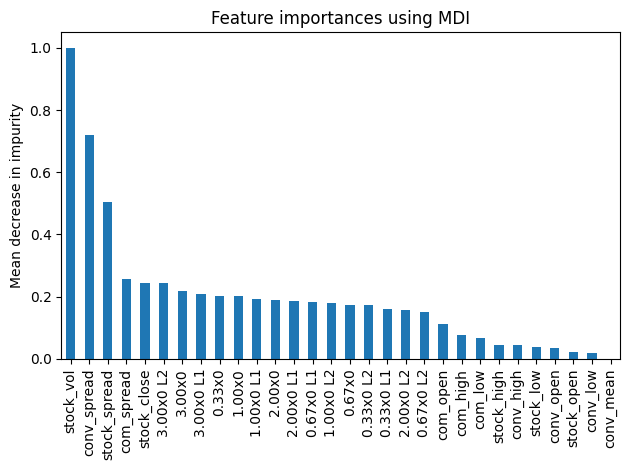

In [18]:
importance_mean = df_with_importance.mean()
importance_mean = (importance_mean-importance_mean.min())/(importance_mean.max()-importance_mean.min())
importance_mean = importance_mean.sort_values(ascending=False)
fig, ax = plt.subplots()
importance_mean[:30].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()